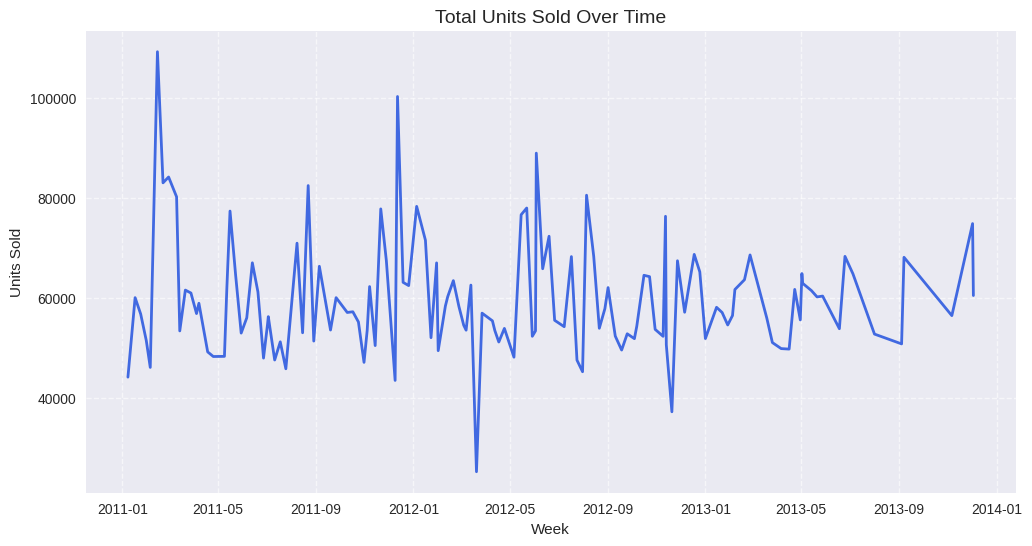

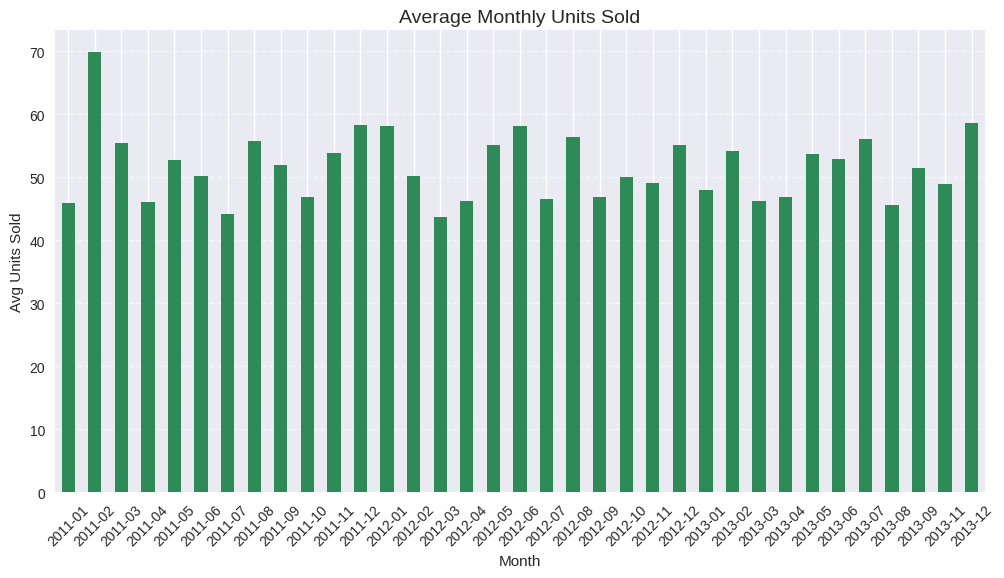

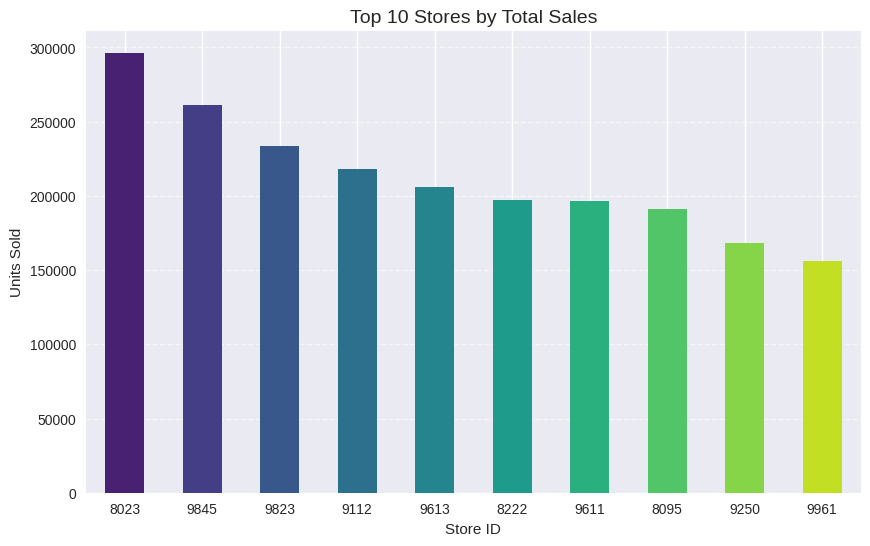

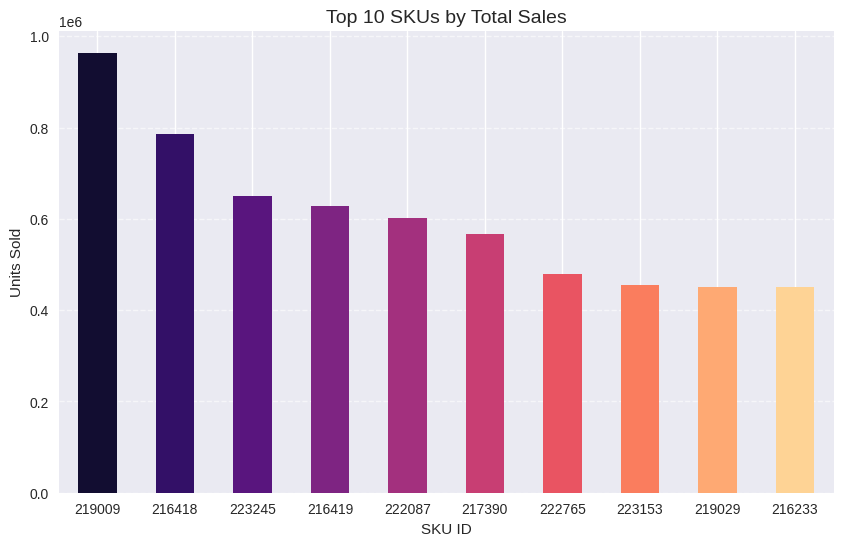

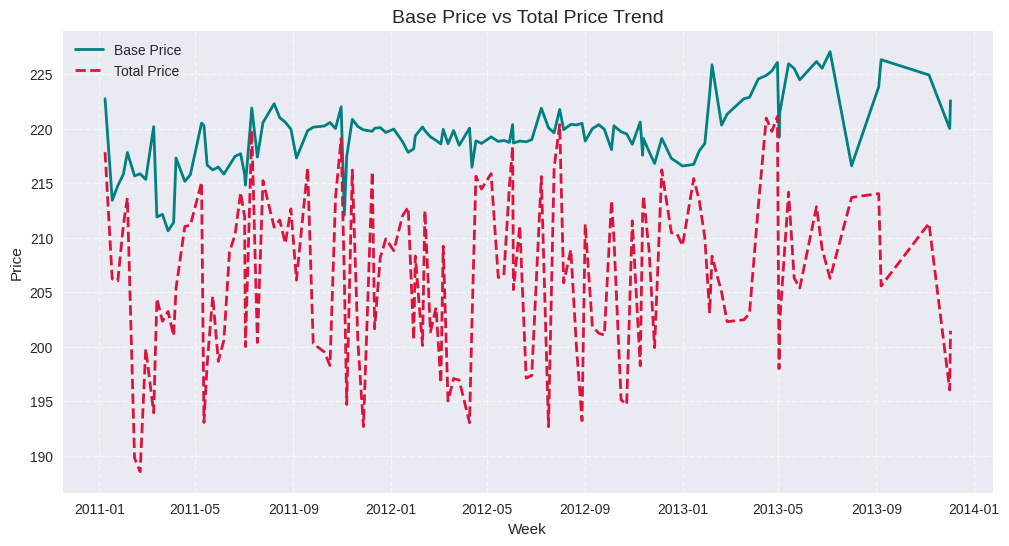


Shape of df_ml before train-test split:
(127, 8)

Head of df_ml before train-test split:


,week,units_sold,base_price,total_price,sku_id,lag_1,lag_2,lag_3
3,2011-01-31,51467,215.833214,211.193019,28,56752.0,60029.0,44134.0
4,2011-02-05,46077,217.827597,213.663019,28,51467.0,56752.0,60029.0
5,2011-02-14,109207,215.681461,189.787175,28,46077.0,51467.0,56752.0
6,2011-02-21,82986,215.876396,188.531201,28,109207.0,46077.0,51467.0
7,2011-02-28,84153,215.355130,199.825097,28,82986.0,109207.0,46077.0


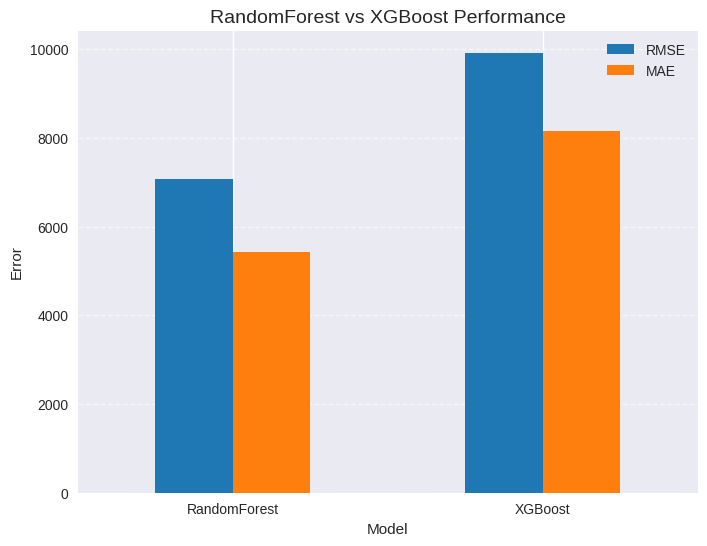

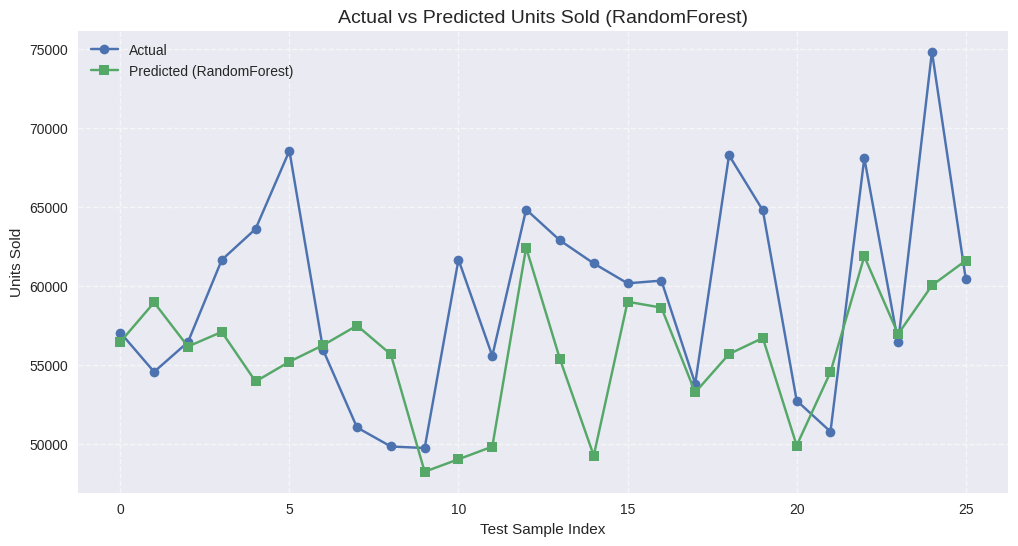

Model Comparison:
           Model         RMSE          MAE
0  RandomForest  7081.338592  5418.058269
1       XGBoost  9921.017287  8148.846191

Best Model: RandomForest


In [17]:
# -------------------------
# Inventory Forecasting & Visualization
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------
# Load Data
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/inv.csv")

# Convert week column to datetime
df['week'] = pd.to_datetime(df['week'])

# -------------------------
# Basic Cleaning
# -------------------------
# Fill missing numeric with mean
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

# Drop irrelevant columns
df = df.drop(['record_ID','is_featured_sku','is_display_sku'], axis=1, errors="ignore")

# -------------------------
# Visualization 1: Total Units Sold Over Time
# -------------------------
plt.figure(figsize=(12,6))
weekly_sales = df.groupby("week")["units_sold"].sum()
plt.plot(weekly_sales.index, weekly_sales.values, color="royalblue", linewidth=2)
plt.title("Total Units Sold Over Time", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Visualization 2: Monthly Average Units Sold
# -------------------------
df["month"] = df["week"].dt.to_period("M")
monthly_sales = df.groupby("month")["units_sold"].mean()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind="bar", color="seagreen")
plt.title("Average Monthly Units Sold", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Avg Units Sold")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Visualization 3: Top 10 Stores by Total Sales
# -------------------------
store_sales = df.groupby("store_id")["units_sold"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
import seaborn as sns

# Assume store_sales is a pandas Series or DataFrame
colors = sns.color_palette("viridis", len(store_sales))  # generate viridis colors

store_sales.plot(kind="bar", color=colors)

plt.title("Top 10 Stores by Total Sales", fontsize=14)
plt.xlabel("Store ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Visualization 4: Top 10 SKUs by Total Sales
# -------------------------
sku_sales = df.groupby("sku_id")["units_sold"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
import seaborn as sns

# Assume sku_sales is a pandas Series or DataFrame
colors = sns.color_palette("magma", len(sku_sales))  # generate colors from magma palette

sku_sales.plot(kind="bar", color=colors)

plt.title("Top 10 SKUs by Total Sales", fontsize=14)
plt.xlabel("SKU ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Visualization 5: Base Price vs Total Price Trend
# -------------------------
price_trend = df.groupby("week")[["base_price","total_price"]].mean()

plt.figure(figsize=(12,6))
plt.plot(price_trend.index, price_trend["base_price"], label="Base Price", color="teal", linewidth=2)
plt.plot(price_trend.index, price_trend["total_price"], label="Total Price", color="crimson", linewidth=2, linestyle="--")
plt.title("Base Price vs Total Price Trend", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# ML Forecasting Prep (Weekly Aggregation)
# -------------------------
df_ml = df.groupby("week").agg({
    'units_sold':'sum',
    'base_price':'mean',
    'total_price':'mean',
    'sku_id':'nunique'
}).reset_index()

# Lag features
df_ml['lag_1'] = df_ml['units_sold'].shift(1)
df_ml['lag_2'] = df_ml['units_sold'].shift(2)
df_ml['lag_3'] = df_ml['units_sold'].shift(3)
df_ml = df_ml.dropna()

print("\nShape of df_ml before train-test split:")
print(df_ml.shape)
print("\nHead of df_ml before train-test split:")
display(df_ml.head())

# Train-test split
X = df_ml[['base_price','total_price','sku_id','lag_1','lag_2','lag_3']]
y = df_ml['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------
# Train Models
# -------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

# Metrics
# Calculate RMSE manually as squared=False is not supported
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)


metrics = pd.DataFrame({
    'Model':['RandomForest','XGBoost'],
    'RMSE':[rf_rmse, xgb_rmse],
    'MAE':[rf_mae, xgb_mae]
})

# -------------------------
# Visualization 6: Model Comparison
# -------------------------
metrics.set_index('Model')[['RMSE','MAE']].plot(kind='bar', figsize=(8,6), color=['#1f77b4','#ff7f0e'])
plt.title("RandomForest vs XGBoost Performance", fontsize=14)
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Visualization 7: Actual vs Predicted (Best Model)
# -------------------------
best_model = "RandomForest" if rf_rmse < xgb_rmse else "XGBoost"
best_pred = rf_pred if rf_rmse < xgb_rmse else xgb_pred

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(best_pred, label=f"Predicted ({best_model})", marker="s")
plt.title(f"Actual vs Predicted Units Sold ({best_model})", fontsize=14)
plt.xlabel("Test Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -------------------------
# Print Results
# -------------------------
print("Model Comparison:\n", metrics)
print(f"\nBest Model: {best_model}")